# Managing solid waste in Central Portugal project

This is the front-end program used for solving the optimization models discussed in the project. All models described are derived from the paper: _Managing solid waste through discrete location analysis: A case study in central Portugal_ of Antunes et al (2001) (https://doi.org/10.1057/palgrave.jors.2602422) 

Models:

1. Original model from Antunes et al (2001)
2. Modified model from Antunes et al (2001) without the $m$ penalty term
3. Extended model using data from 2019 and considering recycling centres

The models are instantiated as `Pyomo` objects and are solved using FICO Xpress Optimizer. Geographic visualization is done using `geopandas`. The `get_basura.py` helper script with all the required preprocessing was developed for a smoother experience.

To run this program, ensure the below libraries are correctly installed and run all cells.

---

In [1]:
# Import core libraries

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import geopandas as gp
from shapely.geometry import Point, Polygon, LineString

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# Pyomo
from pyomo.environ import *

# Misc libraries
import os

# Scripting library
import get_basura as gb

## Original model from Antunes et al (2001)

In [2]:
# Max distances
demax = 25
dlmax = 125

# Bring the data as dictionaries
q_j, dist_jk_dist_jl, dist_kl, w_jk0, f_jk_f_jl, g_kl = [i for i in gb.get_data(demax, dlmax)]

# Parameters
c_c = 0.045
c_u = 0.128571

q = sum(q_j.values())

# s_k = 204400 # original value from Dr Antunes
s_k = 182500 # 500 ton/day capacity

m = 1E6

In [3]:
# Step 0: Instantiate a model object
model_2001 = ConcreteModel()
model_2001.dual = Suffix(direction=Suffix.IMPORT)

# Step 1: Define index sets
J = list(q_j.keys())
K = list(q_j.keys())
L = list(q_j.keys())
J1 = ["Arouca", "Estarreja", "Oliveira de Azemeis", "Sao Joao da Madeira", "Sever do Vouga", "Gois", "Lousa", "Pampilhosa da Serra", "Penela", "Vila Nova Poiares", "Ansiao", "Castanheira de Pera", "Pedrogao Grande"]
K1 = ["Estarreja", "Oliveira de Azemeis", "Sever do Vouga", "Gois", "Pampilhosa da Serra", "Ansiao"]

# Step 2: Define the decision variables
model_2001.w_jk = Var(J, K, within= Binary)
model_2001.v_jl = Var(J, L, within=Binary)
model_2001.y_k = Var(K, within=Binary)
model_2001.z_l = Var(L, within=Binary)
model_2001.x_kl = Var(K,L, domain = NonNegativeReals)

# Step 3: Objective function
def obj_rule(model_2001):
    return sum( c_u * dist_jk_dist_jl[j,k] * q_j[j] * model_2001.w_jk[j,k] for j in J for k in K)+\
        sum( c_u * dist_jk_dist_jl[j,l] * q_j[j] * model_2001.v_jl[j,l] for j in J for l in L)+\
        sum( c_c * dist_kl[k,l] * model_2001.x_kl[k,l] for k in K for l in L) + sum( m*model_2001.y_k[k] for k in K)

model_2001.Cost = Objective(rule=obj_rule, sense = minimize)

# Step 4: Constraints              
def rule_1(model_2001,J):
    return sum( model_2001.w_jk[J,k] for k in K ) + \
           sum( model_2001.v_jl[J,l] for l in L ) == 1 
    
def rule_2(model_2001,K):
    return sum( q_j[j]*model_2001.w_jk[j, K] for j in J ) == sum( model_2001.x_kl[K,l] for l in L )  
    
def rule_3(model_2001,J,K):
    return model_2001.w_jk[J,K] <= f_jk_f_jl[J,K]*model_2001.y_k[K]

def rule_4(model_2001,J,L):
    return model_2001.v_jl[J,L] <= f_jk_f_jl[J,L]*model_2001.z_l[L]
   
def rule_5(model_2001,K,L):
    return model_2001.x_kl[K,L] <= g_kl[K,L]*q*model_2001.z_l[L]

def rule_6(model_2001,K):
    return sum(q_j[j]*model_2001.w_jk[j,K] for j in J)<=s_k*model_2001.y_k[K]

def rule_7(model_2001):
    return sum(model_2001.z_l[l] for l in L) == 1

def rule_8(model_2001, J1, K1):
    return model_2001.w_jk[J1,K1] == w_jk0[J1, K1]

model_2001.C_1 = Constraint( J, rule=rule_1 )
model_2001.C_2 = Constraint( K, rule=rule_2 )
model_2001.C_3 = Constraint( J, K, rule=rule_3 )
model_2001.C_4 = Constraint( J, L, rule=rule_4 )
model_2001.C_5 = Constraint( K, L, rule = rule_5)
model_2001.C_6 = Constraint( K, rule = rule_6 )
model_2001.C_7 = Constraint( rule = rule_7)
model_2001.C_8 = Constraint(J1, K1, rule = rule_8) 

# Call Xpress and solve
results_2001 = SolverFactory('amplxpress').solve(model_2001)
results_2001.write()


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 4075
  Number of variables: 3960
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: XPRESS 34.01.05\x3a Global search complete; Best integer solution found 10327415.82064062; 3 integer solutions have been found; 3 branch and bound nodes; No basis.
  Termination condition: optimal
  Id: 2
  Error rc: 0
  Time: 1.859196424484253
# ----------------------------------------------------------
#   Solution Information
# ----------

### Results

In [4]:
# Output detailed solution
header = "Optimal solution"
print(f"\n{header}")
print(f"="*len(header))

if 'ok' == str(results_2001.Solver.status):
    print(f"Optimal value = € {model_2001.Cost():.2f}")
    t_cost = model_2001.Cost() - sum( m*model_2001.y_k[k]() for k in K)
    print(f"Transportation cost = € {t_cost:.2f}")

    print("\nTransfer stations:")
    for k in K:
        if(model_2001.y_k[k]() == 1):
            print(k, model_2001.y_k[k]())
    
    print("\nIncinerator:")
    for l in L:
        if(model_2001.z_l[l]() == 1):
            print(l, model_2001.z_l[l]())

else:
    print("No Valid Solution Found")


Optimal solution
Optimal value = € 10327415.82
Transportation cost = € 1327415.82

Transfer stations:
Estarreja 1.0
Ilhavo 1.0
Oliveira de Azemeis 1.0
Sever do Vouga 1.0
Coimbra 1.0
Gois 1.0
Montemor-o-Velho 1.0
Pampilhosa da Serra 1.0
Ansiao 1.0

Incinerator:
Agueda 1.0


### Visualization

In [5]:
# Fill lists with the optimization results 

# Transfer stations
y = []

for k in K:
    if(model_2001.y_k[k]() == 1):
        y.append(k)

#Incinerator
z = []

for l in L:
    if(model_2001.z_l[l]() == 1):
        z.append(l)

# Link between municipalities and transfer stations
links_ts = []

for k in K:
    for j in J:
        if(model_2001.w_jk[j, k]() == 1):
            links_ts.append((k, j))

# Link between municipalities and the incinerator
links_inc = []

for l in L:
    for j in J:
        if(model_2001.v_jl[j, l]() == 1):
            links_inc.append((l, j))

# Get the coordinates
ts_new, ts_exist, inc, mun, w_jk, v_jl = [i for i in gb.get_coord(y, z, links_ts, links_inc, K1)]

### GIS
- Incinerator and transfer stations

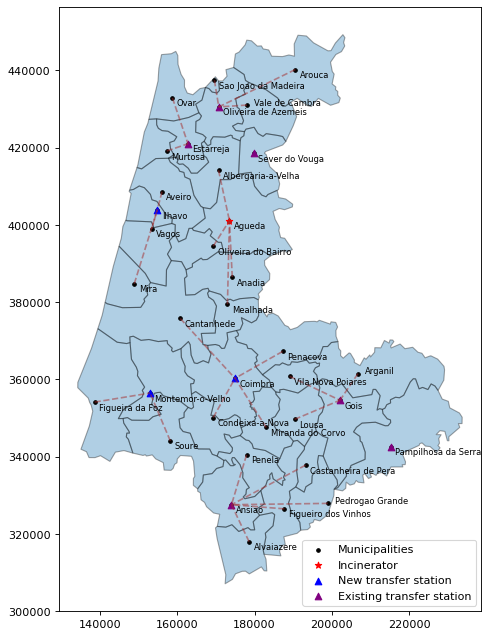

In [6]:
gis_map = gb.create_gis(ts_new, ts_exist, inc, w_jk, v_jl)
gis_map

---
## Modified model from Antunes et al (2001)

A minor change is proposed in the objective function from Antunes et al (2001) where the $m$ term is not considered and a constraint is imposed on the maximum number of new transfer stations to be built in the network. This change does not alter the optimal locations of the incinerator nor the transfer stations; however, this modification enforces only cost terms in the objective function.

In [7]:
# Max distances
demax = 30
dlmax = 125

# Bring the data as dictionaries
q_j, dist_jk_dist_jl, dist_kl, w_jk0, f_jk_f_jl, g_kl = [i for i in gb.get_data(demax, dlmax)]

# Parameters
c_c = 0.045
c_u = 0.128571

q = sum(q_j.values())

# s_k = 204400 # original value from Dr Antunes
s_k = 182500 # 500 ton/day capacity

m = 1E6

In [8]:
# Step 0: Instantiate a model object
model = ConcreteModel()
model.dual = Suffix(direction=Suffix.IMPORT)

# Step 1: Define index sets
J = list(q_j.keys())
K = list(q_j.keys())
L = list(q_j.keys())
J1 = ["Arouca", "Estarreja", "Oliveira de Azemeis", "Sao Joao da Madeira", "Sever do Vouga", "Gois", "Lousa", "Pampilhosa da Serra", "Penela", "Vila Nova Poiares", "Ansiao", "Castanheira de Pera", "Pedrogao Grande"]
K1 = ["Estarreja", "Oliveira de Azemeis", "Sever do Vouga", "Gois", "Pampilhosa da Serra", "Ansiao"]

# Step 2: Define the decision variables
model.w_jk = Var(J, K, within= Binary)
model.v_jl = Var(J, L, within=Binary)
model.y_k = Var(K, within=Binary)
model.z_l = Var(L, within=Binary)
model.x_kl = Var(K,L, domain = NonNegativeReals)

# Step 3: Objective function
def obj_rule(model):
    return sum( c_u * dist_jk_dist_jl[j,k] * q_j[j] * model.w_jk[j,k] for j in J for k in K)+\
        sum( c_u * dist_jk_dist_jl[j,l] * q_j[j] * model.v_jl[j,l] for j in J for l in L)+\
        sum( c_c * dist_kl[k,l] * model.x_kl[k,l] for k in K for l in L) #+ sum( m*model.y_k[k] for k in K)

model.Cost = Objective(rule=obj_rule, sense = minimize)

# Step 4: Constraints              
def rule_1(model,J):
    return sum( model.w_jk[J,k] for k in K ) + \
           sum( model.v_jl[J,l] for l in L ) == 1 
    
def rule_2(model,K):
    return sum( q_j[j]*model.w_jk[j, K] for j in J ) == sum( model.x_kl[K,l] for l in L )  
    
def rule_3(model,J,K):
    return model.w_jk[J,K] <= f_jk_f_jl[J,K]*model.y_k[K]

def rule_4(model,J,L):
    return model.v_jl[J,L] <= f_jk_f_jl[J,L]*model.z_l[L]
   
def rule_5(model,K,L):
    return model.x_kl[K,L] <= g_kl[K,L]*q*model.z_l[L]

def rule_6(model,K):
    return sum(q_j[j]*model.w_jk[j,K] for j in J)<=s_k*model.y_k[K]

def rule_7(model):
    return sum(model.z_l[l] for l in L) == 1

def rule_8(model, J1, K1):
    return model.w_jk[J1,K1] == w_jk0[J1, K1]

def rule_9(model):
    return sum(model.y_k[k] for k in K) <= 9

model.C_1 = Constraint( J, rule=rule_1 )
model.C_2 = Constraint( K, rule=rule_2 )
model.C_3 = Constraint( J, K, rule=rule_3 )
model.C_4 = Constraint( J, L, rule=rule_4 )
model.C_5 = Constraint( K, L, rule = rule_5)
model.C_6 = Constraint( K, rule = rule_6 )
model.C_7 = Constraint( rule = rule_7)
model.C_8 = Constraint(J1, K1, rule = rule_8) 
model.C_9 = Constraint( rule = rule_9) # limit number of transfer stations without using the m term

# Call Xpress and solve
results = SolverFactory('amplxpress').solve(model)
results.write()


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 4076
  Number of variables: 3960
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: XPRESS 34.01.05\x3a Global search complete; Best integer solution found 1260219.1368269662; 9 integer solutions have been found; 5 branch and bound nodes; No basis.
  Termination condition: optimal
  Id: 2
  Error rc: 0
  Time: 2.3973934650421143
# ----------------------------------------------------------
#   Solution Information
# --------

### Results

In [9]:
# Output detailed solution
header = "Optimal solution"
print(f"\n{header}")
print(f"="*len(header))

if 'ok' == str(results.Solver.status):
    print(f"Optimal value = € {model.Cost():.2f}")

    print("\nTransfer stations:")
    for k in K:
        if(model.y_k[k]() == 1):
            print(k, model.y_k[k]())
    
    print("\nIncinerator:")
    for l in L:
        if(model.z_l[l]() == 1):
            print(l, model.z_l[l]())

else:
    print("No Valid Solution Found")


Optimal solution
Optimal value = € 1260219.14

Transfer stations:
Aveiro 1.0
Estarreja 1.0
Oliveira de Azemeis 1.0
Sever do Vouga 1.0
Coimbra 1.0
Figueira da Foz 1.0
Gois 1.0
Pampilhosa da Serra 1.0
Ansiao 1.0

Incinerator:
Agueda 1.0


### Visualization

In [10]:
# Fill lists with the optimization results 

# Transfer stations
y = []

for k in K:
    if(model.y_k[k]() == 1):
        y.append(k)

#Incinerator
z = []

for l in L:
    if(model.z_l[l]() == 1):
        z.append(l)

# Link between municipalities and transfer stations
links_ts = []

for k in K:
    for j in J:
        if(model.w_jk[j, k]() == 1):
            links_ts.append((k, j))

# Link between municipalities and the incinerator
links_inc = []

for l in L:
    for j in J:
        if(model.v_jl[j, l]() == 1):
            links_inc.append((l, j))

# Get the coordinates
ts_new, ts_exist, inc, mun, w_jk, v_jl = [i for i in gb.get_coord(y, z, links_ts, links_inc, K1)]

#### GIS

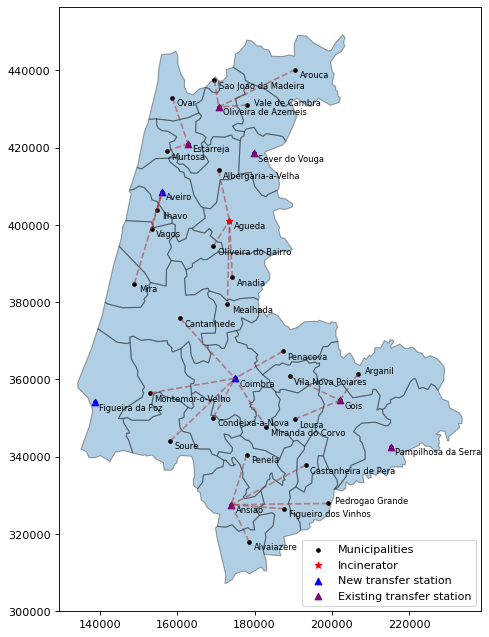

In [11]:
gis_map = gb.create_gis(ts_new, ts_exist, inc, w_jk, v_jl)
gis_map

---
## Extended model
Recycling centers are now included in the network. Data from 2019 is used for recycling and non-recycling waste generation. This information was obtained from the Portuguese Institute of Statistics (INE.pt). 

Transportation costs are updated to 2019 using the Price index (Índice de Preços no Consumidor - IPC) from the Portuguese Institute of Statistics (INE.pt)

In [12]:
# Max distances
demax = 30
dlmax = 125
drmax = 30

# Bring the new data
new_data = gb.get_new_data(demax, dlmax, drmax)

q_j, q_r, q_jr_max, dist_jk_dist_jl, dist_kl, w_jk0, f_jk_f_jl, g_kl, g_jk, d_jk_tri, d_jk_tri_bin, weight_prod = [i for i in new_data]

In [13]:
# Parameters
update_factor = 1.34970214712478 # IPC update factor (from 2001 to 2019)

c_c = 0.045 * update_factor
c_u = 0.128571 * update_factor

weight = 100

q = sum(q_j.values())

# s_k = 204400 # original value from Dr Antunes
s_k = 182500 # 500 ton/day capacity

m = 1E6

# Step 0: Instantiate a model object
model_extended = ConcreteModel()
model_extended.dual = Suffix(direction=Suffix.IMPORT)

# Step 1: Define index sets
J = list(q_j.keys())
K = list(q_j.keys())
L = list(q_j.keys())
J1 = ["Arouca", "Estarreja", "Oliveira de Azemeis", "Sao Joao da Madeira", "Sever do Vouga", "Gois", "Lousa", "Pampilhosa da Serra", "Penela", "Vila Nova Poiares", "Ansiao", "Castanheira de Pera", "Pedrogao Grande"]
K1 = ["Estarreja", "Oliveira de Azemeis", "Sever do Vouga", "Gois", "Pampilhosa da Serra", "Ansiao"]

# Step 2: Define the decision variables
model_extended.w_jk = Var(J, K, within= Binary)
model_extended.v_jl = Var(J, L, within=Binary)
model_extended.y_k = Var(K, within=Binary)
model_extended.z_l = Var(L, within=Binary)
model_extended.x_kl = Var(K,L, domain = NonNegativeReals)
model_extended.x_linear_k = Var(J, K, domain = NonNegativeReals)
model_extended.y_linear_k = Var(J, K, domain = NonNegativeReals)

# new Decision Variables
model_extended.X_k = Var(K, within = Binary) # If a recycling center is built in municipality "k"
model_extended.u_jk = Var(J, K, within= Binary) # Link between municipality "j" to recycle center "k"

# Step 3: Objective function
def obj_rule(model):
    return sum(c_u * dist_jk_dist_jl[j,k] * q_j[j] * model_extended.w_jk[j,k] for j in J for k in K)+\
        sum(c_u * dist_jk_dist_jl[j,l] * q_j[j] * model_extended.v_jl[j,l] for j in J for l in L)+\
        sum(c_c * dist_kl[k,l] * model_extended.x_kl[k,l] for k in K for l in L) +\
        sum(c_u * dist_jk_dist_jl[j,k] * q_r[j] * model_extended.u_jk[j,k] for j in J for k in K) -\
        sum(weight * d_jk_tri[j, k] * model_extended.x_linear_k[j, k] for j in J for k in K) -\
        sum(weight * d_jk_tri[j, k] * model_extended.y_linear_k[j, k] for j in J for k in K)

model_extended.Cost = Objective(rule=obj_rule, sense = minimize)

# Step 4: Constraints              
def rule_1(model_extended,J):
    return sum( model_extended.w_jk[J,k] for k in K ) + \
           sum( model_extended.v_jl[J,l] for l in L ) == 1

def rule_2(model_extended,J):
    return sum( model_extended.u_jk[J,k] for k in K ) == 1  
    
def rule_3(model_extended,K):
    return sum( q_j[j]*model_extended.w_jk[j, K] for j in J ) == sum( model_extended.x_kl[K,l] for l in L )  
    
def rule_4(model_extended,J,K):
    return model_extended.w_jk[J,K] <= f_jk_f_jl[J,K]*model_extended.y_k[K]

def rule_5(model_extended,J,K):
    return model_extended.u_jk[J,K] <= g_jk[J,K]*model_extended.X_k[K]

def rule_6(model_extended,J,L):
    return model_extended.v_jl[J,L] <= f_jk_f_jl[J,L]*model_extended.z_l[L]
   
def rule_7(model_extended,K,L):
    return model_extended.x_kl[K,L] <= g_kl[K,L]*q*model_extended.z_l[L]

def rule_8(model_extended,K):
    return sum(q_j[j]*model_extended.w_jk[j,K] for j in J) <= s_k*model_extended.y_k[K]

def rule_9(model_extended, K):
    return sum(q_r[j]*model_extended.u_jk[j,K] for j in J) <= s_k*model_extended.X_k[K]

def rule_10(model_extended):
    return sum(model_extended.z_l[l] for l in L) == 1

def rule_11(model_extended, J1, K1):
    return model_extended.w_jk[J1,K1] == w_jk0[J1, K1]

def rule_12(model_extended):
    return sum(model_extended.y_k[k] for k in K) <= 9

def rule_13(model_extended):
    return sum(model_extended.X_k[k] for k in K) <= 9

def rule_14(model_extended, J, K):
    return d_jk_tri_bin[J, K] * model_extended.x_linear_k[J, K] <= model_extended.X_k[J]

def rule_14_b(model_extended, J, K):
    return d_jk_tri_bin[J, K] * model_extended.y_linear_k[J, K] <= model_extended.y_k[J]

def rule_15(model_extended, J, K):
    return d_jk_tri_bin[J, K] * model_extended.x_linear_k[J, K] <= model_extended.X_k[K]

def rule_15_b(model_extended, J, K):
    return d_jk_tri_bin[J, K] * model_extended.y_linear_k[J, K] <= model_extended.y_k[K]

def rule_16(model_extended, J, K):
    return model_extended.x_linear_k[J, K] <= 1

def rule_16_b(model_extended, J, K):
    return model_extended.y_linear_k[J, K] <= 1

model_extended.C_1 = Constraint( J, rule=rule_1 )
model_extended.C_2 = Constraint( J, rule=rule_2 )
model_extended.C_3 = Constraint( K, rule=rule_3 )
model_extended.C_4 = Constraint( J, K, rule=rule_4 )
model_extended.C_5 = Constraint(J, K, rule = rule_5)
model_extended.C_6 = Constraint( J, L, rule=rule_6 )
model_extended.C_7 = Constraint( K, L, rule = rule_7)
model_extended.C_8 = Constraint( K, rule = rule_8 )
model_extended.C_9 = Constraint( K, rule = rule_9 )
model_extended.C_10 = Constraint( rule = rule_10)
model_extended.C_11 = Constraint(J1, K1, rule = rule_11) 
model_extended.C_12 = Constraint( rule = rule_12) # limit number of transfer stations without using the m term
model_extended.C_13 = Constraint( rule = rule_13) # limit number of recycling centers
model_extended.C_14 = Constraint( J, K, rule = rule_14) # linearize the quadratic problem
model_extended.C_15 = Constraint( J, K, rule = rule_15) # linearize the quadratic problem
model_extended.C_16 = Constraint( J, K, rule = rule_16) # linearize the quadratic problem
model_extended.C_14_b = Constraint( J, K, rule = rule_14_b) # linearize the quadratic problem for ts
model_extended.C_15_b = Constraint( J, K, rule = rule_15_b) # linearize the quadratic problem for ts
model_extended.C_16_b = Constraint( J, K, rule = rule_16_b) # linearize the quadratic problem for ts

# Call Xpress and solve
results_ext = SolverFactory('amplxpress').solve(model_extended)

results_ext.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 13221
  Number of variables: 7884
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: XPRESS 34.01.05\x3a Global search complete; Best integer solution found 1106411.5060740667; 28 integer solutions have been found; 80635 branch and bound nodes; No basis.
  Termination condition: optimal
  Id: 2
  Error rc: 0
  Time: 257.83540892601013
# ----------------------------------------------------------
#   Solution Information
# --

### Results

In [20]:
# Output detailed solution
header = "Optimal solution"
print(f"\n{header}")
print(f"="*len(header))

if 'ok' == str(results.Solver.status):
    print(f"Optimal value = € {model_extended.Cost():.2f}")
    w = sum(weight*model_extended.X_k[j]() * d_jk_tri[j, k] * model_extended.X_k[k]() for j in J for k in K) + sum( weight * d_jk_tri[j, k] * model_extended.y_linear_k[j, k]() for j in J for k in K)
    t_cost = model_extended.Cost() + w
    ratio = w / t_cost
    print(f"Transportation costs = €{t_cost:.2f}")
    print(f"Weight = {w:.2f}")
    print(f"ratio: {ratio}")

    print("\nTransfer stations:")
    for k in K:
        if(model_extended.y_k[k]() == 1):
            print(k, model_extended.y_k[k]())
    
    print("\nIncinerator:")
    for l in L:
        if(model_extended.z_l[l]() == 1):
            print(l, model_extended.z_l[l]())

    print("\nRecycling centers:")
    for k in K:
        if(model_extended.X_k[k]() == 1):
            print(k, model_extended.X_k[k]())

else:
    print("No Valid Solution Found")


Optimal solution
Optimal value = € 1106411.51
Transportation costs = €1693551.51
Weight = 587140.00
ratio: 0.3466915519806583

Transfer stations:
Aveiro 1.0
Estarreja 1.0
Oliveira de Azemeis 1.0
Sever do Vouga 1.0
Coimbra 1.0
Figueira da Foz 1.0
Gois 1.0
Pampilhosa da Serra 1.0
Ansiao 1.0

Incinerator:
Mealhada 1.0

Recycling centers:
Arouca 1.0
Aveiro 1.0
Oliveira de Azemeis 1.0
Ovar 1.0
Arganil 1.0
Coimbra 1.0
Figueira da Foz 1.0
Pampilhosa da Serra 1.0
Figueiro dos Vinhos 1.0


### Visualization

In [15]:
# Fill lists with the optimization results 

# Transfer stations
y = []

for k in K:
    if(model_extended.y_k[k]() == 1):
        y.append(k)

#Incinerator
z = []

for l in L:
    if(model_extended.z_l[l]() == 1):
        z.append(l)

#Recycling centres
x = []

for k in K:
    if(model_extended.X_k[k]() == 1):
        x.append(k)

# Link between municipalities and transfer stations
links_ts = []

for k in K:
    for j in J:
        if(model_extended.w_jk[j, k]() == 1):
            links_ts.append((k, j))

# Link between municipalities and the incinerator
links_inc = []

for l in L:
    for j in J:
        if(model_extended.v_jl[j, l]() == 1):
            links_inc.append((l, j))

# Link between municipalities and recycling centres
links_recs = []

for k in K:
    for j in J:
        if(model_extended.u_jk[j, k]() == 1):
            links_recs.append((k, j))

# Get the coordinates
ts_new, ts_exist, inc, rec, mun, w_jk, v_jl, u_jk = [i for i in gb.get_coord(y, z, links_ts, links_inc, K1, x, links_recs)]

#### GIS

- Incinerator and transfer stations

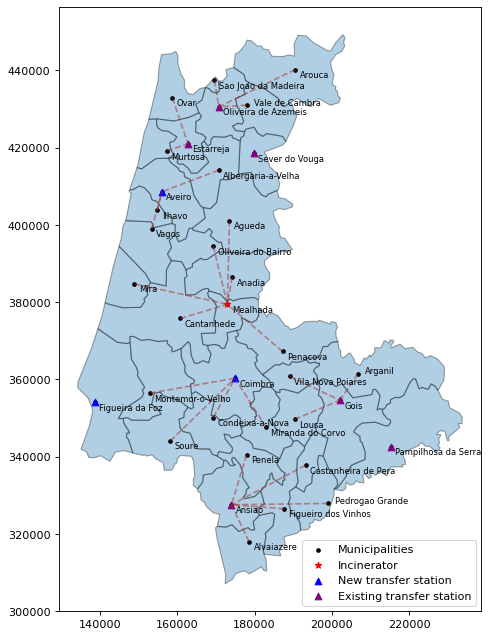

In [16]:
gis_map = gb.create_gis(ts_new, ts_exist, inc, w_jk, v_jl)
gis_map

- Recycling centres

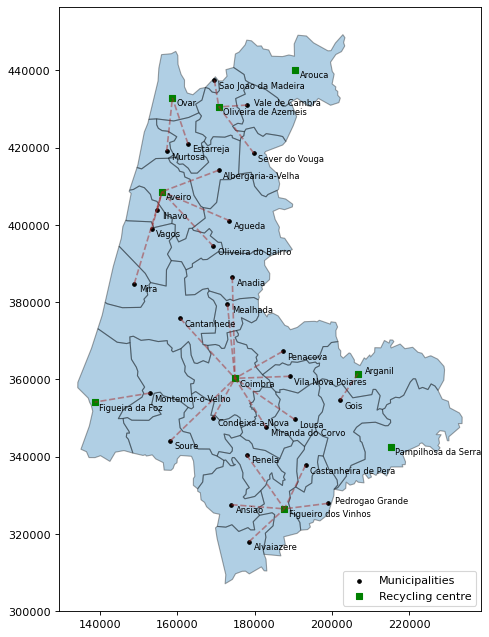

In [17]:
gis_rec_map = gb.create_gis_rec(rec, u_jk)
gis_rec_map

### Extended model (Only one facility per municipality at most case)

In [18]:
# Max distances
demax = 35
dlmax = 125
drmax = 35

# Bring the new data
new_data = gb.get_new_data(demax, dlmax, drmax)

q_j, q_r, q_jr_max, dist_jk_dist_jl, dist_kl, w_jk0, f_jk_f_jl, g_kl, g_jk, d_jk_tri, d_jk_tri_bin, weight_prod = [i for i in new_data]

In [19]:
# Parameters
update_factor = 1.34970214712478 # IPC update factor (from 2001 to 2019)

c_c = 0.045 * update_factor
c_u = 0.128571 * update_factor

weight = 100

q = sum(q_j.values())

# s_k = 204400 # original value from Dr Antunes
s_k = 182500 # 500 ton/day capacity

m = 1E6

# Step 0: Instantiate a model object
model_ext_b = ConcreteModel()
model_ext_b.dual = Suffix(direction=Suffix.IMPORT)

# Step 1: Define index sets
J = list(q_j.keys())
K = list(q_j.keys())
L = list(q_j.keys())
J1 = ["Arouca", "Estarreja", "Oliveira de Azemeis", "Sao Joao da Madeira", "Sever do Vouga", "Gois", "Lousa", "Pampilhosa da Serra", "Penela", "Vila Nova Poiares", "Ansiao", "Castanheira de Pera", "Pedrogao Grande"]
K1 = ["Estarreja", "Oliveira de Azemeis", "Sever do Vouga", "Gois", "Pampilhosa da Serra", "Ansiao"]

# Step 2: Define the decision variables
model_ext_b.w_jk = Var(J, K, within= Binary)
model_ext_b.v_jl = Var(J, L, within=Binary)
model_ext_b.y_k = Var(K, within=Binary)
model_ext_b.z_l = Var(L, within=Binary)
model_ext_b.x_kl = Var(K,L, domain = NonNegativeReals)
model_ext_b.x_linear_k = Var(J, K, domain = NonNegativeReals)
model_ext_b.y_linear_k = Var(J, K, domain = NonNegativeReals)

# new Decision Variables
model_ext_b.X_k = Var(K, within = Binary) # If a recycling center is built in municipality "k"
model_ext_b.u_jk = Var(J, K, within= Binary) # Link between municipality "j" to recycle center "k"

# Step 3: Objective function
def obj_rule(model):
    return sum( c_u * dist_jk_dist_jl[j,k] * q_j[j] * model_ext_b.w_jk[j,k] for j in J for k in K)+\
        sum( c_u * dist_jk_dist_jl[j,l] * q_j[j] * model_ext_b.v_jl[j,l] for j in J for l in L)+\
        sum( c_c * dist_kl[k,l] * model_ext_b.x_kl[k,l] for k in K for l in L) +\
        sum( c_u * dist_jk_dist_jl[j,k] * q_r[j] * model_ext_b.u_jk[j,k] for j in J for k in K ) -\
        sum( weight * d_jk_tri[j, k] * model_ext_b.x_linear_k[j, k] for j in J for k in K) -\
        sum( weight * d_jk_tri[j, k] * model_ext_b.y_linear_k[j, k] for j in J for k in K)

model_ext_b.Cost = Objective(rule=obj_rule, sense = minimize)

# Step 4: Constraints              
def rule_1(model_ext_b,J):
    return sum(model_ext_b.w_jk[J,k] for k in K) + \
           sum(model_ext_b.v_jl[J,l] for l in L) == 1

def rule_2(model_ext_b,J):
    return sum(model_ext_b.u_jk[J,k] for k in K) == 1  
    
def rule_3(model_ext_b,K):
    return sum(q_j[j]*model_ext_b.w_jk[j, K] for j in J) == sum(model_ext_b.x_kl[K,l] for l in L)  
    
def rule_4(model_ext_b,J,K):
    return model_ext_b.w_jk[J,K] <= f_jk_f_jl[J,K]*model_ext_b.y_k[K]

def rule_5(model_ext_b,J,K):
    return model_ext_b.u_jk[J,K] <= g_jk[J,K]*model_ext_b.X_k[K]

def rule_6(model_ext_b,J,L):
    return model_ext_b.v_jl[J,L] <= f_jk_f_jl[J,L]*model_ext_b.z_l[L]
   
def rule_7(model_ext_b,K,L):
    return model_ext_b.x_kl[K,L] <= g_kl[K,L]*q*model_ext_b.z_l[L]

def rule_8(model_ext_b,K):
    return sum(q_j[j]*model_ext_b.w_jk[j,K] for j in J) <= s_k*model_ext_b.y_k[K]

def rule_9(model_ext_b, K):
    return sum(q_r[j]*model_ext_b.u_jk[j,K] for j in J) <= s_k*model_ext_b.X_k[K]

def rule_10(model_ext_b):
    return sum(model_ext_b.z_l[l] for l in L)==1

def rule_11(model_ext_b, J1, K1):
    return model_ext_b.w_jk[J1,K1] == w_jk0[J1, K1]

def rule_12(model_ext_b):
    return sum(model_ext_b.y_k[k] for k in K) <= 9

def rule_13(model_ext_b):
    return sum(model_ext_b.X_k[k] for k in K) <= 9

def rule_14(model_ext_b, J, K):
    return d_jk_tri_bin[J, K] * model_ext_b.x_linear_k[J, K] <= model_ext_b.X_k[J]

def rule_14_b(model_ext_b, J, K):
    return d_jk_tri_bin[J, K] * model_ext_b.y_linear_k[J, K] <= model_ext_b.y_k[J]

def rule_15(model_ext_b, J, K):
    return d_jk_tri_bin[J, K] * model_ext_b.x_linear_k[J, K] <= model_ext_b.X_k[K]

def rule_15_b(model_ext_b, J, K):
    return d_jk_tri_bin[J, K] * model_ext_b.y_linear_k[J, K] <= model_ext_b.y_k[K]

def rule_16(model_ext_b, J, K):
    return model_ext_b.x_linear_k[J, K] <= 1

def rule_16_b(model_ext_b, J, K):
    return model_ext_b.y_linear_k[J, K] <= 1

def rule_17(model_ext_b, K):
    return model_ext_b.X_k[K] + model_ext_b.y_k[K] + model_ext_b.z_l[k] <= 1

model_ext_b.C_1 = Constraint( J, rule=rule_1 )
model_ext_b.C_2 = Constraint( J, rule=rule_2 )
model_ext_b.C_3 = Constraint( K, rule=rule_3 )
model_ext_b.C_4 = Constraint( J, K, rule=rule_4 )
model_ext_b.C_5 = Constraint(J, K, rule = rule_5)
model_ext_b.C_6 = Constraint( J, L, rule=rule_6 )
model_ext_b.C_7 = Constraint( K, L, rule = rule_7)
model_ext_b.C_8 = Constraint( K, rule = rule_8 )
model_ext_b.C_9 = Constraint( K, rule = rule_9 )
model_ext_b.C_10 = Constraint( rule = rule_10)
model_ext_b.C_11 = Constraint(J1, K1, rule = rule_11) 
model_ext_b.c_12 = Constraint( rule = rule_12) # limit number of transfer stations without using the m term
model_ext_b.c_13 = Constraint( rule = rule_13) # limit number of recycling centers
model_ext_b.c_14 = Constraint( J, K, rule = rule_14) # linearize the quadratic problem
model_ext_b.c_15 = Constraint( J, K, rule = rule_15) # linearize the quadratic problem
model_ext_b.c_16 = Constraint( J, K, rule = rule_16) # linearize the quadratic problem
model_ext_b.c_14_b = Constraint( J, K, rule = rule_14_b) # linearize the quadratic problem for ts
model_ext_b.c_15_b = Constraint( J, K, rule = rule_15_b) # linearize the quadratic problem for ts
model_ext_b.c_16_b = Constraint( J, K, rule = rule_16_b) # linearize the quadratic problem for ts
model_ext_b.C_17 = Constraint( K, rule = rule_17 ) # only one facility is to be located in each municipality

# Call Xpress and solve
results_ext_b = SolverFactory('amplxpress').solve(model_ext_b)

results_ext_b.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 13257
  Number of variables: 7884
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: XPRESS 34.01.05\x3a Global search complete; Best integer solution found 1160952.4230249946; 26 integer solutions have been found; 23423 branch and bound nodes; No basis.
  Termination condition: optimal
  Id: 2
  Error rc: 0
  Time: 76.70267105102539
# ----------------------------------------------------------
#   Solution Information
# ---

### Results

In [21]:
# Output detailed solution
header = "Optimal solution"
print(f"\n{header}")
print(f"="*len(header))

if 'ok' == str(results_ext_b.Solver.status):
    print(f"Optimal value = € {model_ext_b.Cost():.2f}")
    w = sum(weight*model_ext_b.X_k[j]() * d_jk_tri[j, k]*model_ext_b.X_k[k]() for j in J for k in K) + sum(weight*d_jk_tri[j, k]*model_ext_b.y_linear_k[j, k]() for j in J for k in K)
    t_cost = model_ext_b.Cost() + w
    ratio = w / t_cost
    print(f"Transportation costs = €{t_cost:.2f}")
    print(f"Weight = {w:.2f}")
    print(f"ratio: {ratio}")

    print("\nTransfer stations:")
    for k in K:
        if(model_ext_b.y_k[k]() == 1):
            print(k, model_ext_b.y_k[k]())
    
    print("\nIncinerator:")
    for l in L:
        if(model_ext_b.z_l[l]() == 1):
            print(l, model_ext_b.z_l[l]())

    print("\nRecycling centers:")
    for k in K:
        if(model_ext_b.X_k[k]() == 1):
            print(k, model_ext_b.X_k[k]())
            
else:
    print("No Valid Solution Found")


Optimal solution
Optimal value = € 1160952.42
Transportation costs = €1738922.42
Weight = 577970.00
ratio: 0.33237250399852475

Transfer stations:
Aveiro 1.0
Estarreja 1.0
Oliveira de Azemeis 1.0
Sever do Vouga 1.0
Coimbra 1.0
Figueira da Foz 1.0
Gois 1.0
Pampilhosa da Serra 1.0
Ansiao 1.0

Incinerator:
Mealhada 1.0

Recycling centers:
Arouca 1.0
Ilhavo 1.0
Ovar 1.0
Vale de Cambra 1.0
Arganil 1.0
Condeixa-a-Nova 1.0
Montemor-o-Velho 1.0
Alvaiazere 1.0
Pedrogao Grande 1.0


### Visualization

In [22]:
# Fill lists with the optimization results 

# Transfer stations
y = []

for k in K:
    if(model_ext_b.y_k[k]() == 1):
        y.append(k)

#Incinerator
z = []

for l in L:
    if(model_ext_b.z_l[l]() == 1):
        z.append(l)

#Recycling centres
x = []

for k in K:
    if(model_ext_b.X_k[k]() == 1):
        x.append(k)

# Link between municipalities and transfer stations
links_ts = []

for k in K:
    for j in J:
        if(model_ext_b.w_jk[j, k]() == 1):
            links_ts.append((k, j))

# Link between municipalities and the incinerator
links_inc = []

for l in L:
    for j in J:
        if(model_ext_b.v_jl[j, l]() == 1):
            links_inc.append((l, j))

# Link between municipalities and recycling centres
links_recs = []

for k in K:
    for j in J:
        if(model_ext_b.u_jk[j, k]() == 1):
            links_recs.append((k, j))

# Get the coordinates
ts_new, ts_exist, inc, rec, mun, w_jk, v_jl, u_jk = [i for i in gb.get_coord(y, z, links_ts, links_inc, K1, x, links_recs)]

#### GIS

- Incinerator and transfer stations

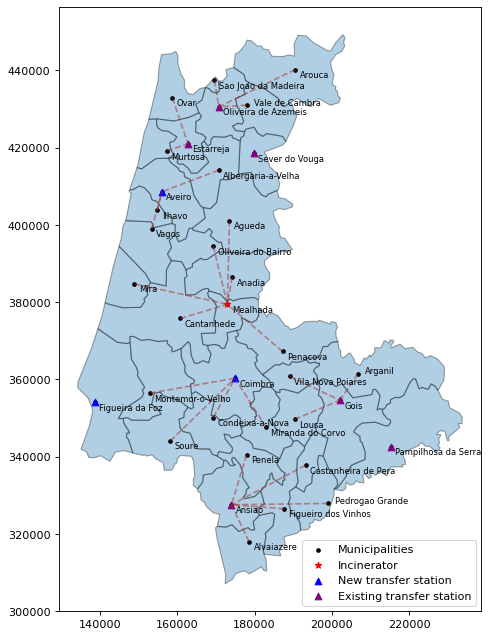

In [23]:
gis_map = gb.create_gis(ts_new, ts_exist, inc, w_jk, v_jl)
gis_map

- Recycling centres

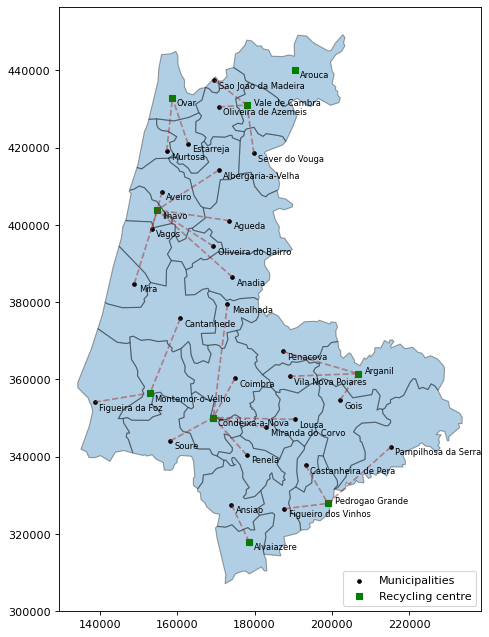

In [24]:
gis_rec_map = gb.create_gis_rec(rec, u_jk)
gis_rec_map